In [1]:
# The legendary MNIST dataset

import warnings
warnings.filterwarnings('ignore')

# Something here is not working...
from sklearn.datasets import fetch_mldata

# ... do this instead
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import os

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

fetch_mnist()

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
# 70k images with 28×28=780 pixels

(70000, 784)

In [4]:
y.shape

(70000,)

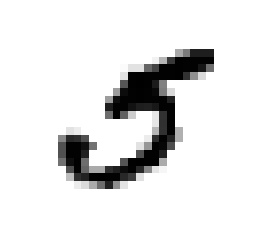

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
# Looks like a 5. The label says:
y[36000]

5.0

In [7]:
# Mnist is already split in train/test, first 60k and last 10k images
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
import numpy as np

# Images might be ordered and that will affect predictions, so let's shuffle
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [9]:
# We're training a 5-detector

y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=23)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=23, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
sgd_clf.predict([some_digit-1])

array([False])

# Performance Measures

### Problems with standard measurements

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96585, 0.96155, 0.9619 ])

Everything above 90%. Nice.

In [14]:
# Very dumb classifier that just says nothing is ever a 5
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91045, 0.90895, 0.90955])

Also above 90%. Why? Because there only a few images of the number 5. Lesson learned, we have to be carefull evaluating classifiers, particularly above skewed data.

### Confusion Matrix

In [16]:
# The general idea is to count the number of times instances of class A are classified as class B.
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53640,   939],
       [ 1275,  4146]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 51,568 of them were correctly classified as non-5s (they are called true negatives), while the remaining 3,011 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 652 were wrongly classified as non-5s (false negatives), while the remaining 4,770 were correctly classified as 5s (true positives).

In [18]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # From conf. matrix == 4770 / (4770 + 3011)

0.8153392330383481

In [20]:
recall_score(y_train_5, y_train_pred) # From conf. matrix == 4770 / (4770 + 651)

0.7648035417819591

In [21]:
# F1 score, a ratio of precision and recall
# Keep in mind the F1 score favors classifiers that have similar precision and recall
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7892632781267848

In [22]:
# Lets return a score for each instance, instead of th prediction

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([72213.44637205])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This shows that raising the threshold decreases recall, because we know that some_digit actually is a 5.

In [25]:
# We can get all the scores instead of all the predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
# Plot the precision/recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

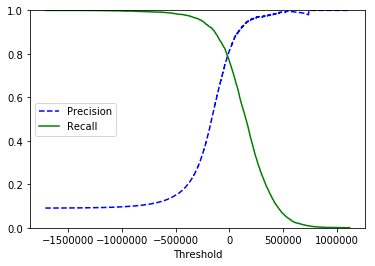

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [28]:
# We can look at this plot and manually define a precision of, say, 95%,
#   whose threshold is arond 300k
y_train_pred_90 = (y_scores > 300000)

precision_score(y_train_5, y_train_pred_90)

0.9700073152889539

In [29]:
# Recall suffers considerably
recall_score(y_train_5, y_train_pred_90)

0.2446043165467626

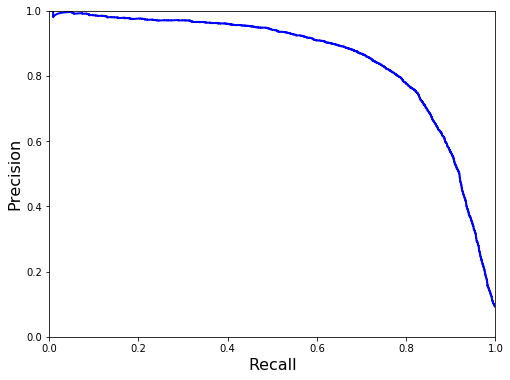

In [30]:
# It's also useful to plot precision vs. recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity.

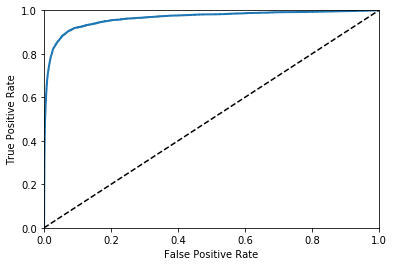

In [31]:
# First compute  FPR and TNR
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
# Are under ROC curve can serve as a measurement
from sklearn.metrics import roc_auc_score

# A perfect classifier will have ROC area = 1, a purely random classifier ROC AUC = 0.5
roc_auc_score(y_train_5, y_scores)
0.96244965559671547

0.9624496555967155

In [33]:
# Let's train a randomforest and compare ROC curves
from sklearn.ensemble import RandomForestClassifier

# In randomforest there is no decision_function() method, Instead it has a predict_proba() method
# predict_proba() returns array containing a row per instance and a column per class,
#   each containing the probability that the given instance belongs to the given class
#   (e.g., 70% chance that the image represents a 5)
forest_clf = RandomForestClassifier(random_state=23)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [34]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

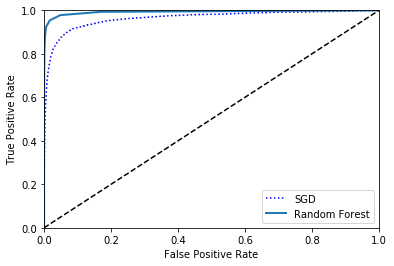

In [35]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9927810640384098

In [37]:
y_rforest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

precision_score(y_train_5, y_rforest_pred)

0.986034138771891

In [38]:
recall_score(y_train_5, y_rforest_pred)

0.8205128205128205

# Multiclass Classification

Multiclass classification with binary predictors using one-versus-one (OvO) or one-versus-all (OvA).

In [39]:
# Here sklearn auto detects that a binary classifier is being used for multi-classe prediction
#   and automatically does OvA
# Sklearn trains 10 binary classifiers (for the 10 classes), gets the decision scores and
#   and selectes the class with the highest score.
sgd_clf.fit(X_train, y_train)  # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([5.])

In [40]:
# We can run decision_function, and what we will actually obtain is the result of each individual classifier
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-140474.70599334, -566518.92849323, -428145.40057837,
        -191029.64611896, -314017.21467362,   72213.44637205,
        -776728.4817142 , -428620.48390826, -792651.01778979,
        -582947.1269849 ]])

In [41]:
# The highest score is indeed the one corresponding to class 5
np.argmax(some_digit_scores)

5

In [42]:
sgd_clf.classes_[5]

5.0

In [43]:
# We can force OvO or OvA using OneVsOneClassifier and OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=23))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [44]:
# Training a random forest is easy and this classifier is multi-class by design
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [45]:
# 70% chance of being a 5, 20% chance of being a 3, 10% of being a 8
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0.1, 0.8, 0. , 0. , 0. , 0.1]])

In [46]:
# As always, model needs to be cross-validated
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84423115, 0.8639432 , 0.86367955])

In [47]:
# We can still do better, look at the impact of variable scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91006799, 0.90974549, 0.91108666])

# Error Analysis

Now we would explore data preparation options, try multiple models, shortlist the best ones and fine-tune their hyperparameters using GridSearchCV. In this case we'll go straight to error analysis.

In [48]:
# Looking at the confusion Matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5740,    2,   19,   11,   13,   46,   42,    9,   37,    4],
       [   1, 6455,   52,   23,    6,   40,    7,   11,  135,   12],
       [  53,   39, 5312,  105,   92,   24,   87,   61,  168,   17],
       [  44,   41,  141, 5343,    2,  235,   35,   53,  138,   99],
       [  22,   27,   32,    9, 5387,    7,   55,   29,   78,  196],
       [  64,   44,   37,  176,   73, 4620,  112,   24,  172,   99],
       [  31,   20,   43,    2,   46,   86, 5641,    3,   46,    0],
       [  24,   23,   63,   34,   56,   11,    6, 5801,   15,  232],
       [  46,  149,   69,  147,   14,  157,   55,   26, 5039,  149],
       [  40,   30,   32,   89,  167,   36,    2,  198,   75, 5280]])

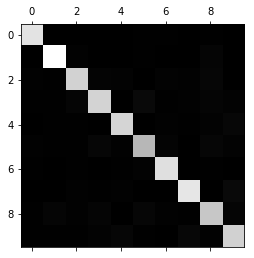

In [49]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

It's slightly darker for the number 5. This might mean it performs worse for 5's, or there are less proportionally. Let's check both.

In [50]:
# This calculates the error rate, rather than the absolute error we were using
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

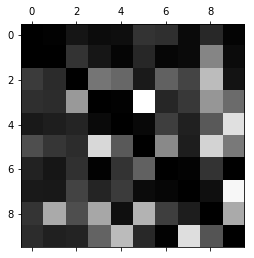

In [51]:
# Fill the diagonal with 0
# REMEMBER that rows represent actual classes, while columns represent predicted classes
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [52]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

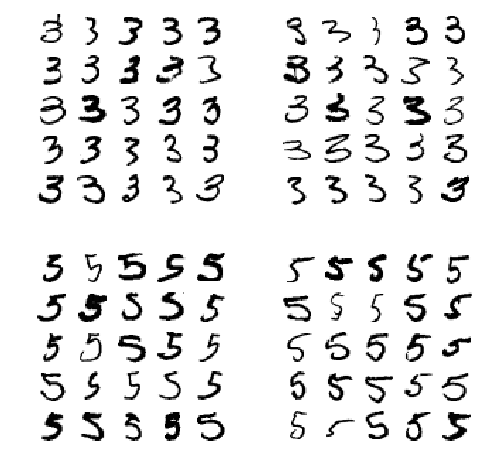

In [53]:
# Plotting some examples
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classifier

Think identify various faces in a picture, for each picture the system outputs a series of labels.

In [54]:
# KNeighbors supports multilabel, not all do
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [55]:
# Lets see what it says for number 5
knn_clf.predict([some_digit])

array([[False,  True]])

In [56]:
# There are many ways to validate a multilabel classifier
# One example if to calculate the F1 score for each individual label, then average

# Commented because it takes forever
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

This assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code.

# Multioutput Classification

Let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

In [57]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

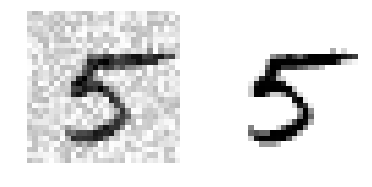

In [63]:
some_index = 5500
plt.subplot(121);  # plot_digits(X_test_mod[some_index])
plt.imshow(X_test_mod[some_index].reshape(28, 28), cmap = matplotlib.cm.binary,
           interpolation="nearest");
plt.axis("off")
plt.subplot(122);  # plot_digits(y_test_mod[some_index])
plt.imshow(y_test_mod[some_index].reshape(28, 28), cmap = matplotlib.cm.binary,
           interpolation="nearest");
plt.axis("off")
plt.show()